In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import pickle

## Data Loading

In [2]:
def data_load(file_path):
    if file_path.endswith(".csv"):
        df = pd.read_csv(file_path)
        return df
    else:
        df = pd.read_excel(file_path)
        return df

In [3]:
df = data_load("customer_churn.csv")

## EDA

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [8]:
df.drop(["Surname", "RowNumber", "CustomerId"],axis =1, inplace = True)

In [9]:
df.shape

(10000, 11)

In [10]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [11]:
cat_cols = [col for col in df.columns if df[col].dtype == "object"]
num_cols = [col for col in df.columns if df[col].dtype != "object"]
print(f"The length of numerical columns is {len(num_cols)} \nThe length of categorical columns is {len(cat_cols)}")

The length of numerical columns is 9 
The length of categorical columns is 2


In [12]:
df_stat = []
def custom_summary(df):
    for col in num_cols:
        col_stat = {
                'feature_name' : col,
                'count'        : df[col].count(),
                'mean'         : df[col].mean(),
                'var'          : df[col].var(),
                'std'          : df[col].std(),
                'min'          : df[col].min(),
                'q1'           : df[col].quantile(0.25),
                'q2'           : df[col].quantile(0.50),
                'q3'           : df[col].quantile(0.75),
                'max'          : df[col].max(),
                'skewness'     : df[col].skew() , 
                'kurtosis'     : df[col].kurt()
        }
        df_stat.append(col_stat)
    summary_df = pd.DataFrame(df_stat)
    skewness_label = []
    for val in summary_df['skewness']:
        if val <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < val <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < val < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= val < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= val < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif val >= 1:
            skewness_label.append('Highly Positively Skewed')
    summary_df['skewness_label'] = skewness_label
    
    kurtosis_label = []
    for val in summary_df['kurtosis']:
        if val >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif val <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    summary_df['kurtosis_label'] = kurtosis_label

    outliers_label = []
    for col in df.columns:
        if df[col].dtype != 'object':
            q1 = df[col].quantile(0.25)
            q2 = df[col].quantile(0.50)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lv = q1 - (1.5*iqr)
            uv = q3 + (1.5*iqr)
            if len(df[(df[col] < lv) | (df[col] > uv)]) > 0:
                outliers_label.append("Have Outliers")
            else:
                outliers_label.append("No Outliers")
    summary_df['outliers_label'] = outliers_label
    
    return summary_df
    

    



In [13]:
custom_summary(df)

,feature_name,count,mean,var,std,min,q1,q2,q3,max,skewness,kurtosis,skewness_label,kurtosis_label,outliers_label
0,CreditScore,10000,650.528800,9.341860e+03,96.653299,350.00,584.00,652.000,718.0000,850.00,-0.071607,-0.425726,Fairly Negatively Skewed,Mesokurtic Curve,Have Outliers
1,Age,10000,38.921800,1.099941e+02,10.487806,18.00,32.00,37.000,44.0000,92.00,1.011320,1.395347,Highly Positively Skewed,Leptokurtic Curve,Have Outliers
2,Tenure,10000,5.012800,8.364673e+00,2.892174,0.00,3.00,5.000,7.0000,10.00,0.010991,-1.165225,Fairly Positively Skewed,Platykurtic Curve,No Outliers
3,Balance,10000,76485.889288,3.893436e+09,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,-0.141109,-1.489412,Fairly Negatively Skewed,Platykurtic Curve,No Outliers
4,NumOfProducts,10000,1.530200,3.383218e-01,0.581654,1.00,1.00,1.000,2.0000,4.00,0.745568,0.582981,Moderately Positively Skewed,Mesokurtic Curve,Have Outliers
5,HasCrCard,10000,0.705500,2.077905e-01,0.455840,0.00,0.00,1.000,1.0000,1.00,-0.901812,-1.186973,Moderately Negatively Skewed,Platykurtic Curve,No Outliers
6,IsActiveMember,10000,0.515100,2.497970e-01,0.499797,0.00,0.00,1.000,1.0000,1.00,-0.060437,-1.996747,Fairly Negatively Skewed,Platykurtic Curve,No Outliers
7,EstimatedSalary,10000,100090.239881,3.307457e+09,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,0.002085,-1.181518,Fairly Positively Skewed,Platykurtic Curve,No Outliers
8,Exited,10000,0.203700,1.622225e-01,0.402769,0.00,0.00,0.000,0.0000,1.00,1.471611,0.165671,Highly Positively Skewed,Mesokurtic Curve,Have Outliers


In [14]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [15]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

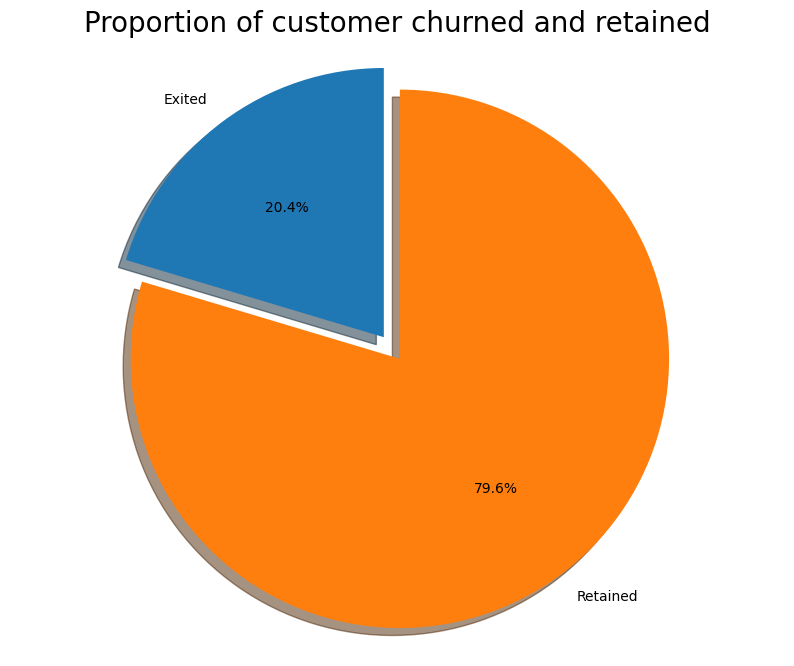

In [16]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

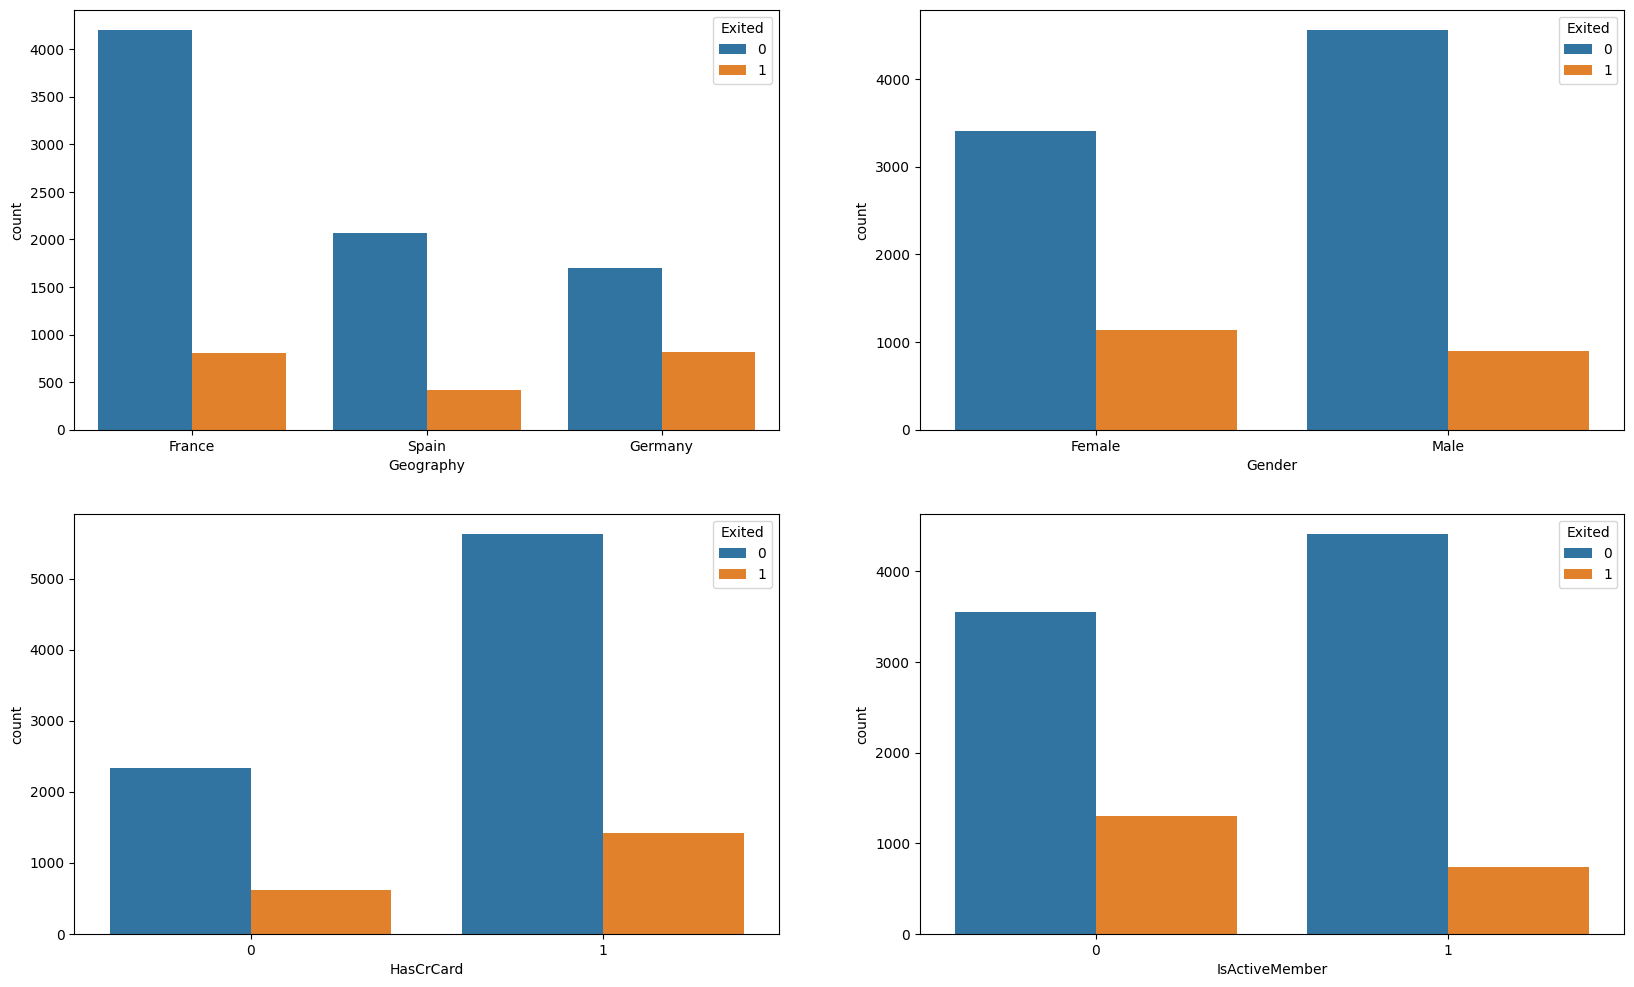

In [17]:
fig,ax= plt.subplots(2,2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=ax[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=ax[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=ax[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=ax[1][1])
plt.show()


<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

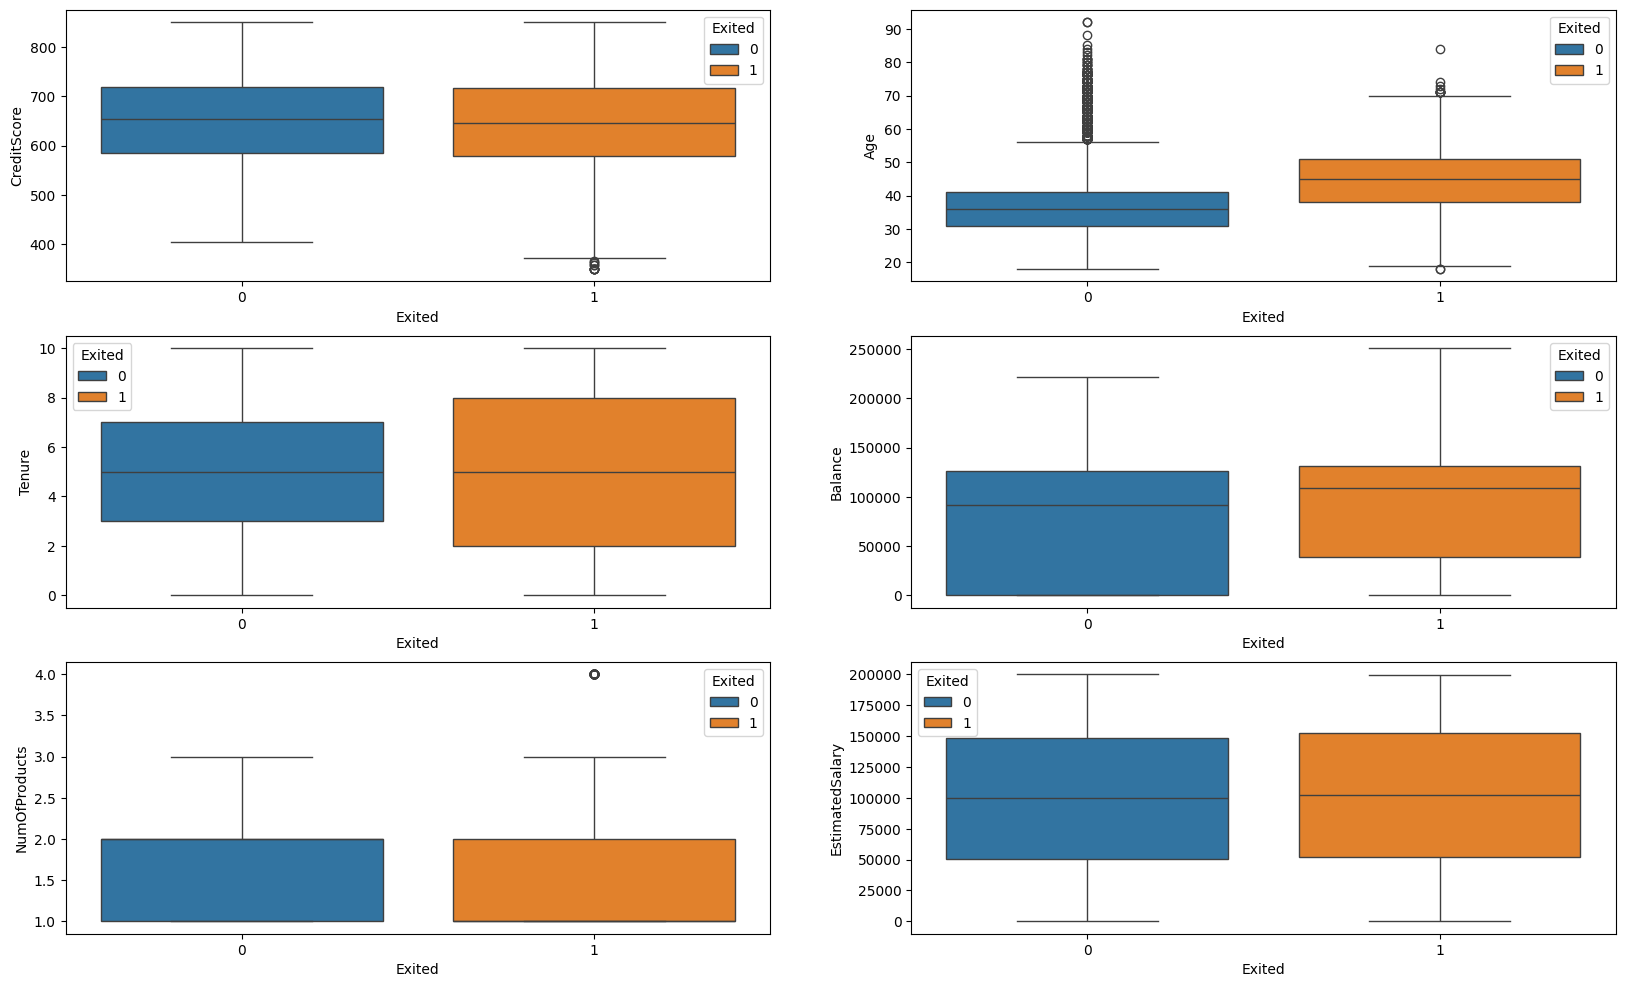

In [18]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


<Axes: >

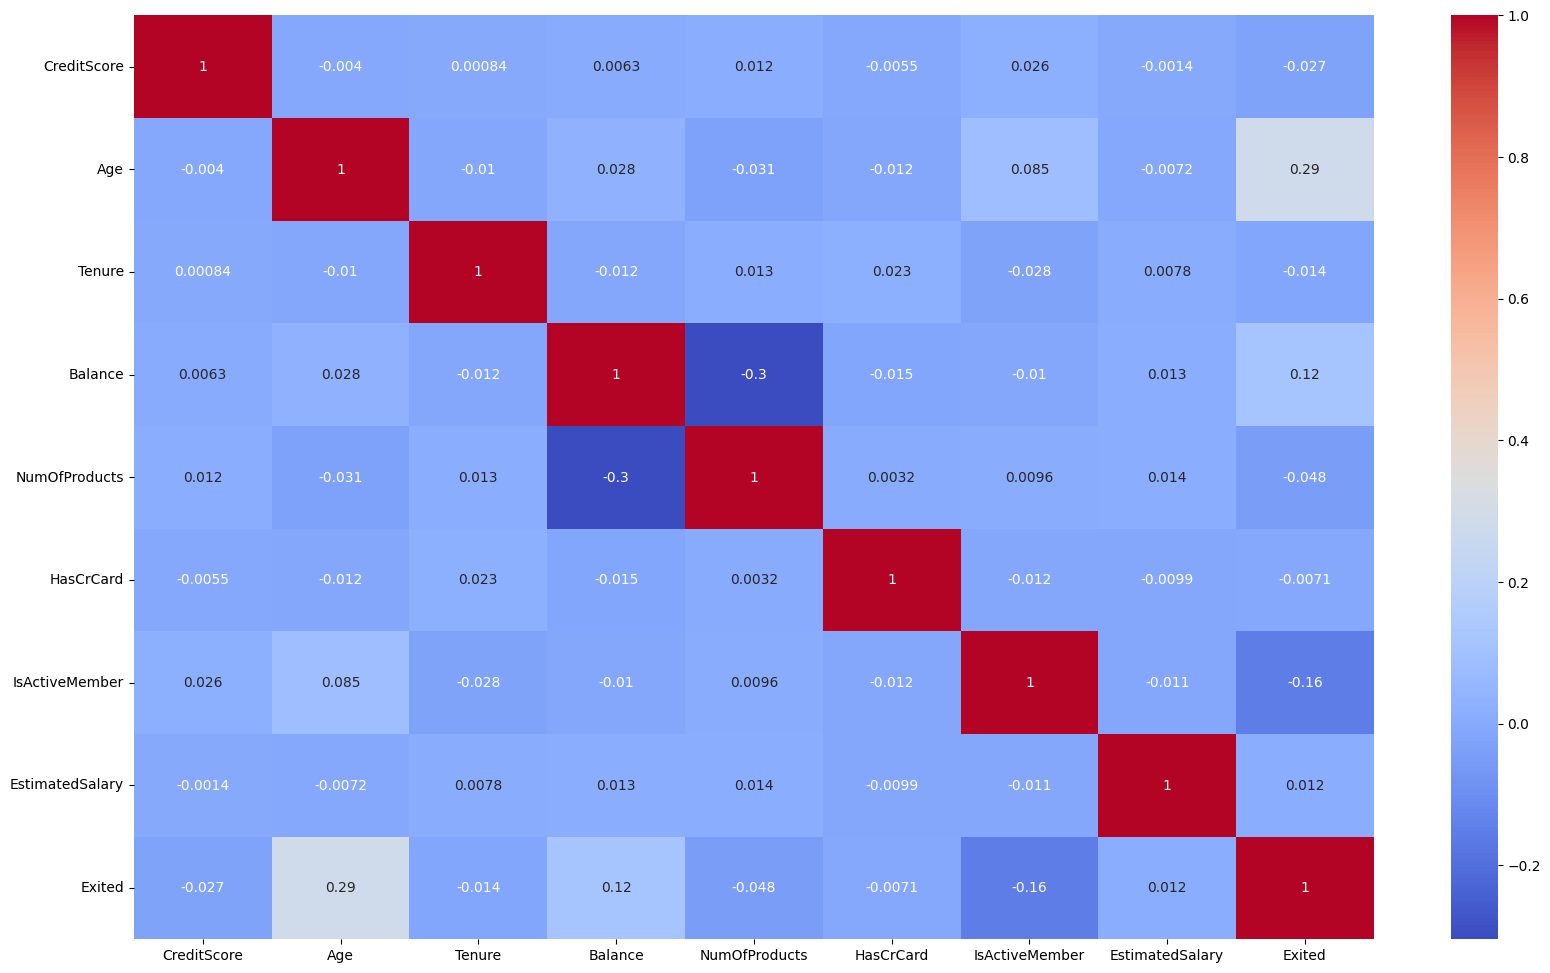

In [19]:
c = df[num_cols].corr()
display(c)
plt.figure(figsize=(20, 12))
sns.heatmap(c, annot =True, cmap = 'coolwarm')

In [32]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [20]:
corr_with_target = []
for col in num_cols:
    if col != 'Exited':
        corr_dict = {
        'feature_name' : col,
        'corr_val' : df[col].corr(df['Exited'])}
    corr_with_target.append(corr_dict)
corr_df = pd.DataFrame(corr_with_target)
corr_df
    

,feature_name,corr_val
0,CreditScore,-0.027094
1,Age,0.285323
2,Tenure,-0.014001
3,Balance,0.118533
4,NumOfProducts,-0.047820
5,HasCrCard,-0.007138
6,IsActiveMember,-0.156128
7,EstimatedSalary,0.012097
8,EstimatedSalary,0.012097


## Train_Test_Split

In [23]:
mlflow.set_tracking_uri?

Signature: mlflow.set_tracking_uri(uri: Union[str, pathlib.Path]) -> None
Docstring:
Set the tracking server URI. This does not affect the
currently active run (if one exists), but takes effect for successive runs.

Args:
    uri:

        - An empty string, or a local file path, prefixed with ``file:/``. Data is stored
          locally at the provided file (or ``./mlruns`` if empty).
        - An HTTP URI like ``https://my-tracking-server:5000``.
        - A Databricks workspace, provided as the string "databricks" or, to use a Databricks
          CLI `profile <https://github.com/databricks/databricks-cli#installation>`_,
          "databricks://<profileName>".
        - A :py:class:`pathlib.Path` instance

.. code-block:: python
    :test:
    :caption: Example

    import mlflow

    mlflow.set_tracking_uri("file:///tmp/my_tracking")
    tracking_uri = mlflow.get_tracking_uri()
    print(f"Current tracking uri: {tracking_uri}")

.. code-block:: text
    :caption: Output

    Curre

In [28]:

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name='bank_customer_churn_model')



2024/05/03 16:29:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/03 16:29:38 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location=('file:///C:/Users/viswanath.c/OneDrive - '
 'Technovert/Projects/ML/bank_customer_churn_prediction/mlruns/1'), creation_time=1714733980010, experiment_id='1', last_update_time=1714733980010, lifecycle_stage='active', name='bank_customer_churn_model', tags={}>

In [ ]:
mlflow.set

In [36]:
# def train_model(data, target_column, categorical_cols, models, test_size=0.2, random_state=42):
#     # Split data into features and target
#     X = data.drop(target_column, axis=1)
#     y = data[target_column]

#     # Perform train-test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#     # Define preprocessing pipeline
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
#         remainder='passthrough')

#     best_f1 = 0
#     best_model = None

#     for model_name, model in models.items():
#         # Append classifier to preprocessing pipeline
#         clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

#         # Train the model
#         clf.fit(X_train, y_train)

#         # Make predictions
#         y_pred = clf.predict(X_test)

#         # Calculate evaluation metrics
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred, average='weighted')
#         recall = recall_score(y_test, y_pred, average='weighted')
#         f1 = f1_score(y_test, y_pred, average='weighted')

#         print("Model:", model_name)
#         print("Accuracy:", accuracy)
#         print("Precision:", precision)
#         print("Recall:", recall)
#         print("F1 Score:", f1)

#         if f1 > best_f1:
#             best_f1 = f1
#             best_model = clf
    
    

    
#     def get_run_name(base_name, existing_run_names):
#         i = 1
#         run_name = base_name + "_" + str(i)
#         while run_name in existing_run_names:
#             i += 1
#             run_name = base_name + "_" + str(i)
#         return run_name
    
#     # Get existing run names
#     existing_run_names = mlflow.search_runs().iloc[:, 0].tolist()
    
#     # Generate a unique run name
#     run_name = get_run_name("run", existing_run_names)
#     with mlflow.start_run(run_name=run_name):
#         mlflow.log_metric("best_f1_score", best_f1)
#         mlflow.sklearn.log_model(best_model, "best_model")

#     # Save the best model to a pickle file
#     with open('best_model.pkl', 'wb') as f:
#         pickle.dump(best_model, f)

# # Define a dictionary of models with hyperparameters
# models = {
#     "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
#     "LogisticRegression": LogisticRegression(C=1.0, random_state=42),
#     "KNN": KNeighborsClassifier(n_neighbors=5),
#     "SVM": SVC(C=1.0, kernel='rbf', random_state=42)
# }

# train_model(df, 'Exited', cat_cols, models)

def train_model(data, target_column, categorical_cols, models, test_size=0.2, random_state=42):
    # Split data into features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # One-hot encode categorical columns
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    X_test_encoded = encoder.transform(X_test[categorical_cols])

    feature_names = list(encoder.get_feature_names_out(categorical_cols))
    X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=feature_names)
    X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=feature_names)

    X_train.drop(categorical_cols, axis=1, inplace=True)
    X_test.drop(categorical_cols, axis=1, inplace=True)

    X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

    best_f1 = 0
    best_model = None

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print("Model:", model_name)
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_encoder = encoder

    def get_run_name(base_name, existing_run_names):
        i = 1
        run_name = base_name + "_" + str(i)
        while run_name in existing_run_names:
            i += 1
            run_name = base_name + "_" + str(i)
        return run_name
    
    # Get existing run names
    existing_run_names = mlflow.search_runs().iloc[:, 0].tolist()
    
    # Generate a unique run name
    run_name = get_run_name("run", existing_run_names)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric("best_f1_score", best_f1)
        mlflow.sklearn.log_model(best_model, "best_model")
        mlflow.sklearn.log_model(best_encoder, "one_hot_encoder")

    # Save the best model and encoder to a pickle file
    with open('best_model.pkl', 'wb') as f:
        pickle.dump((best_model, best_encoder), f)

# Define a dictionary of models with hyperparameters
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "LogisticRegression": LogisticRegression(C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(C=1.0, kernel='rbf', random_state=42)
}

train_model(df, 'Exited', cat_cols, models)

Model: RandomForest
Accuracy: 0.862
Precision: 0.8524650605267606
Recall: 0.862
F1 Score: 0.8464241042645297


C:\Users\viswanath.c\AppData\Local\anaconda3\envs\azure_mlops\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Accuracy: 0.8
Precision: 0.7422197894377661
Recall: 0.8
F1 Score: 0.7403853674057773
Model: KNN
Accuracy: 0.764
Precision: 0.6961490068685839
Recall: 0.764
F1 Score: 0.7203310574775543


C:\Users\viswanath.c\AppData\Local\anaconda3\envs\azure_mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: SVM
Accuracy: 0.8035
Precision: 0.64561225
Recall: 0.8035
F1 Score: 0.7159548100914888


2024/05/06 11:57:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [31]:
dff = mlflow.search_runs()
dff['tags.mlflow.runName']
dff

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.best_f1_score,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name
0,22472be2fa714abbb0800a074b3c48da,1,FINISHED,file:///C:/Users/viswanath.c/OneDrive - Techno...,2024-05-03 10:59:50.665000+00:00,2024-05-03 10:59:59.778000+00:00,0.846857,LOCAL,run_1,"[{""run_id"": ""22472be2fa714abbb0800a074b3c48da""...",viswanath.c,C:\Users\viswanath.c\AppData\Local\anaconda3\e...


In [ ]:
mlflow.start_run?

In [ ]:
mlflow.

In [ ]:
mlflow.get_run?

In [ ]:
mlflow.get_run?

In [ ]:
mlflow.search_runs?

In [40]:
int('Yes')

ValueError: invalid literal for int() with base 10: 'Yes'